# Autocorrelación espacial local

Desde una perspectiva sustantiva, la autocorrelación espacial podría reflejar el funcionamiento de procesos que generan asociación entre los valores en localizaciones cercanas. En estos casos, a continuación se debe realizar un modelado formal de las dimensiones espaciales de los procesos. Por otro lado, la autocorrelación espacial a veces puede surgir de operaciones de procesamiento de datos, en cuyos casos la dependencia es una forma de ruido no aleatorio más que debido a procesos sustantivos.

Por estas razones, la capacidad de determinar si la autocorrelación espacial está presente en un conjunto de datos referenciados geográficamente es un componente crítico de la caja de herramientas de la ciencia de datos espaciales. Dicho esto, las medidas globales de autocorrelación espacial son estadísticas de "mapa completo", lo que significa que la estadística única pertenece al conjunto de datos completo. En otras palabras, las estadísticas de autocorrelación global nos permiten detectar agrupacionesen un conjunto de datos referenciado geográficamente. 

- Por ejemplo, la **I de Moran (MEDIDA GLOBAL) es una buena herramienta para resumir un conjunto de datos en un valor único que informa sobre su grado de agrupación geográfica**. Sin embargo, **no es una medida apropiada para identificar áreas dentro del mapa donde se ubican tipos específicos de valores** (por ejemplo, alto, bajo). En otras palabras, puede decirnos que los valores están agrupados en general, pero no nos informa sobre dónde están los grupos o clusters.

- Las **MEDIDAS LOCALES consideran cada observación individual y operan sobre ellas**, a diferencia del conjunto de datos general, como lo hacen las medidas globales. Por eso, **no son buenos para resumir un mapa, pero permiten obtener más información sobre subconjuntos geográficos interesantes de los datos**. 

## Una ilustración empírica: el referéndum de la UE (BREXIT)


In [1]:
# Display graphics within the notebook
%matplotlib inline

import matplotlib.pyplot as plt  # Graphics
from matplotlib import colors
import seaborn                   # Graphics
import geopandas                 # Spatial data manipulation
import pandas                    # Tabular data manipulation
from pysal.explore import esda   # Exploratory Spatial analytics
from pysal.lib import weights
import contextily                # Background tiles

C:\Users\Julen Montes\Anaconda\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
ref = pandas.read_csv('./data/brexit_vote.csv', 
                      index_col='Area_Code')
ref.info()

<class 'pandas.core.frame.DataFrame'>
Index: 382 entries, E06000031 to E08000036
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       382 non-null    int64  
 1   Region_Code              382 non-null    object 
 2   Region                   382 non-null    object 
 3   Area                     382 non-null    object 
 4   Electorate               382 non-null    int64  
 5   ExpectedBallots          382 non-null    int64  
 6   VerifiedBallotPapers     382 non-null    int64  
 7   Pct_Turnout              382 non-null    float64
 8   Votes_Cast               382 non-null    int64  
 9   Valid_Votes              382 non-null    int64  
 10  Remain                   382 non-null    int64  
 11  Leave                    382 non-null    int64  
 12  Rejected_Ballots         382 non-null    int64  
 13  No_official_mark         382 non-null    int64  
 14  Voting_for_both_a

In [3]:
lads = geopandas.read_file("./data/local_authority_districts.geojson")\
                .set_index('lad16cd')
lads.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 391 entries, E06000001 to W06000023
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    391 non-null    int64   
 1   lad16nm     391 non-null    object  
 2   lad16nmw    22 non-null     object  
 3   bng_e       391 non-null    int64   
 4   bng_n       391 non-null    int64   
 5   long        391 non-null    float64 
 6   lat         391 non-null    float64 
 7   st_areasha  391 non-null    float64 
 8   st_lengths  391 non-null    float64 
 9   geometry    391 non-null    geometry
dtypes: float64(4), geometry(1), int64(3), object(2)
memory usage: 33.6+ KB


In [4]:
db = geopandas.GeoDataFrame(lads.join(ref[['Pct_Leave']]), crs=lads.crs)\
              .to_crs(epsg=3857)\
              [['objectid', 'lad16nm', 'Pct_Leave', 'geometry']]\
              .dropna()
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 380 entries, E06000001 to W06000023
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   objectid   380 non-null    int64   
 1   lad16nm    380 non-null    object  
 2   Pct_Leave  380 non-null    float64 
 3   geometry   380 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(1)
memory usage: 14.8+ KB


In [5]:
db.head()

,objectid,lad16nm,Pct_Leave,geometry
lad16cd,,,,
E06000001,1,Hartlepool,69.57,"MULTIPOLYGON (((-141402.215 7309092.065, -1537..."
E06000002,2,Middlesbrough,65.48,"MULTIPOLYGON (((-136924.099 7281563.141, -1426..."
E06000003,3,Redcar and Cleveland,66.19,"MULTIPOLYGON (((-126588.382 7293641.928, -1260..."
E06000004,4,Stockton-on-Tees,61.73,"MULTIPOLYGON (((-146690.634 7293316.144, -1537..."
E06000010,10,"Kingston upon Hull, City of",67.62,"MULTIPOLYGON (((-35191.009 7134866.244, -39368..."


Y con estos elementos, podemos generar una coropleta para tener una idea rápida de la distribución espacial de los datos que analizaremos. 

Observe cómo usamos algunos ajustes visuales (por ejemplo, transparencia a través del atributo alpha) para hacer que la trama final sea más fácil de leer.

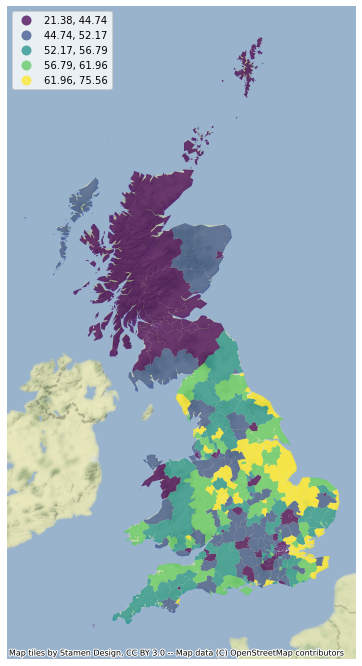

In [6]:
f, ax = plt.subplots(1, figsize=(12, 12))
db.plot(column='Pct_Leave', 
        cmap='viridis', 
        scheme='quantiles',
        k=5, 
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds={"loc": 2},
        ax=ax
       )
contextily.add_basemap(ax, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground,
                       
                      )
ax.set_axis_off()

La pieza final que necesitamos antes de poder profundizar en la autocorrelación espacial es la matriz de pesos espaciales. 

Usaremos ocho vecinos más cercanos para compararlos con el capítulo anterior. 

También estandarizamos las filas de los pesos:

In [9]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = 'R'

## Motivar la autocorrelación espacial local ¶

Para comprender mejor el fundamento de la autorocorrelación local, volveremos a Moran Plot como herramienta gráfica. Primero calculemos el retraso espacial de nuestra variable de interés:

In [10]:
db['w_Pct_Leave'] = weights.spatial_lag.lag_spatial(w, db['Pct_Leave'])

Y sus respectivas versiones estandarizadas, donde restamos la media y dividimos por la desviación estándar:

In [11]:
db['Pct_Leave_std'] = ( db['Pct_Leave'] - db['Pct_Leave'].mean() )\
                    / db['Pct_Leave'].std()
db['w_Pct_Leave_std'] = ( db['w_Pct_Leave'] - db['w_Pct_Leave'].mean() )\
                    / db['w_Pct_Leave'].std()

Técnicamente hablando, crear un diagrama de Moran es muy similar a crear cualquier otro diagrama de dispersión en Python:

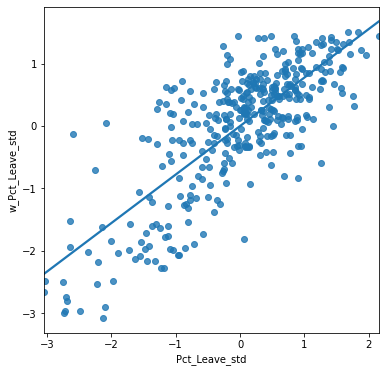

In [12]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(x='Pct_Leave_std', y='w_Pct_Leave_std', data=db, ci=None)
# Display
plt.show()

El uso de valores estandarizados nos permite dividir cada variable (el porcentaje que votó a favor de irse y su rezago espacial) en dos grupos: por encima y por debajo del promedio. 

Esto, a su vez, divide un gráfico de Moran en cuatro cuadrantes, dependiendo de si un área determinada muestra un valor por encima de la media (alto) o por debajo (bajo), y cómo se comporta su retraso espacial:

- Alto-alto (HH)

- Bajo-alto (LH)

- Bajo-bajo (LL)

- Alto-bajo (HL)

Gráficamente, esto se puede capturar de la siguiente manera:

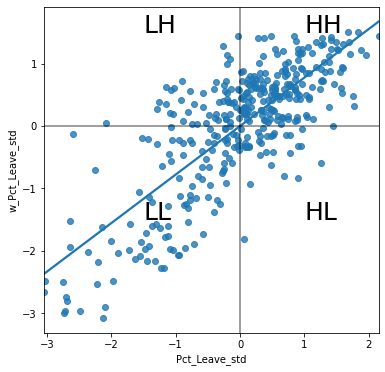

In [13]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(x='Pct_Leave_std', y='w_Pct_Leave_std', data=db, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Add text labels for each quadrant
plt.text(1, 1.5, "HH", fontsize=25)
plt.text(1, -1.5, "HL", fontsize=25)
plt.text(-1.5, 1.5, "LH", fontsize=25)
plt.text(-1.5, -1.5, "LL", fontsize=25)
# Display
plt.show()

## I local de Moran

Hasta ahora hemos clasificado cada observación en el conjunto de datos según su valor y el de sus vecinos. Esto es solo la mitad del camino para identificar áreas de concentración inusual de valores. Para saber si cada una de las ubicaciones es un grupo estadísticamente significativo de un tipo dado, nuevamente necesitamos compararlo con lo que esperaríamos si los datos fueran asignados de una manera completamente aleatoria. Después de todo, por definición, cada observación será de un tipo de otro, según la comparación anterior. Sin embargo, lo que nos interesa es si la fuerza con la que se concentran los valores es inusualmente alta.

Esto es exactamente para lo que están diseñadas las **LISA**. Una descripción más detallada de sus fundamentos estadísticos está más allá del alcance en este contexto, pero proporcionaremos algo de intuición sobre cómo funcionan. **La idea central es identificar casos en los que la comparación entre el valor de una observación y el promedio de sus vecinos sea más similar (HH, LL) o diferente (HL, LH) de lo que esperaríamos por pura casualidad**. El mecanismo para hacer esto es similar al del I de Moran global, pero aplicado en este caso a cada observación, resultando entonces en tantas estadísticas como observaciones originales. 

Las LISA se utilizan ampliamente en muchos campos para identificar grupos de valores en el espacio. Son una herramienta muy útil que puede devolver rápidamente áreas en las que se concentran los valores y proporcionar evidencia sugerente sobre los procesos que podrían estar funcionando. Por eso, tienen un lugar privilegiado en la caja de herramientas exploratoria. 

Ejemplos de contextos en los que las LISA pueden ser útiles incluyen: *identificación de conglomerados espaciales de pobreza en regiones, detección de enclaves étnicos, delimitación de áreas de actividad particularmente alta / baja de cualquier fenómeno, etc.*

En Python, podemos calcular LISA de una manera muy ágil gracias a PySAL:

In [14]:
lisa = esda.moran.Moran_Local(db['Pct_Leave'], w)

C:\Users\Julen Montes\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

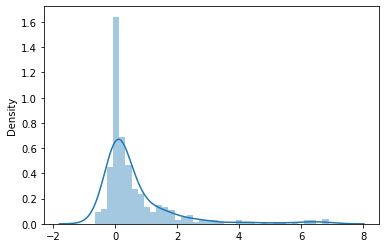

In [15]:
seaborn.distplot(lisa.Is)

Esto revela una distribución bastante sesgada debido al predominio de las formas positivas de asociación espacial. 

Aquí es importante tener en cuenta que los **valores altos positivos** surgen de la simularidad de valores en el espacio, y esto puede deberse a que los valores altos se encuentran al lado de los valores altos o los valores bajos al lado de los valores bajos. Es decir, estos valores muestran una **asociación espacial positiva**.

**Los valores en la cola izquierda** de la densidad representan ubicaciones que muestran una **asociación espacial negativa**. También hay dos formas, un valor alto rodeado de valores bajos o un valor bajo rodeado de observaciones vecinas de alto valor.

Debido a su propia naturaleza, observar el resultado numérico de las LISA no siempre es la forma más útil de explotar toda la información que pueden proporcionar. Recuerde que estamos calculando una estadística para cada observación en los datos, por lo que, si tenemos muchas de ellas, será difícil extraer un patrón significativo. En este contexto, una coropleta puede ayudar.

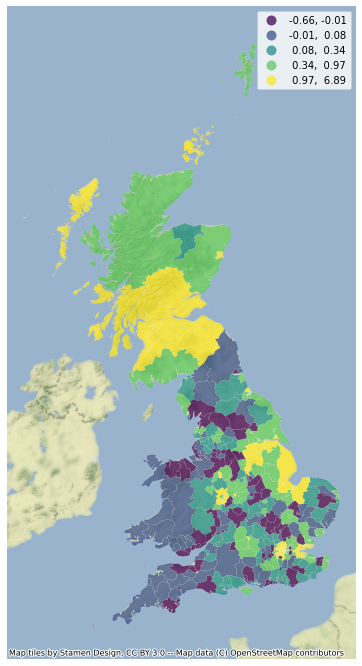

In [16]:
f, ax = plt.subplots(1, figsize=(12,12))
db['Is'] = lisa.Is
db.plot(column='Is', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True, ax=ax);
contextily.add_basemap(ax, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground
                      )
ax.set_axis_off()

Sin embargo, esto no nos informa de ninguna manera sobre qué **tipo de correlación espacial** está experimentando cada área. 

Por ejemplo, ¿las áreas amarillas en Escocia son similares a las del grupo Este de valores altos también? Además, sabemos que los valores alrededor de cero no serán estadísticamente significativos. ¿Cuáles son, por tanto, significativos y no significativos desde un punto de vista estadístico? En otras palabras, *¿cuáles pueden considerarse clústeres estadísticos y cuáles ruido?* 

**Para responder a estas preguntas, necesitamos traer información adicional** que hemos obtenido al calcular las estadísticas de LISA. 

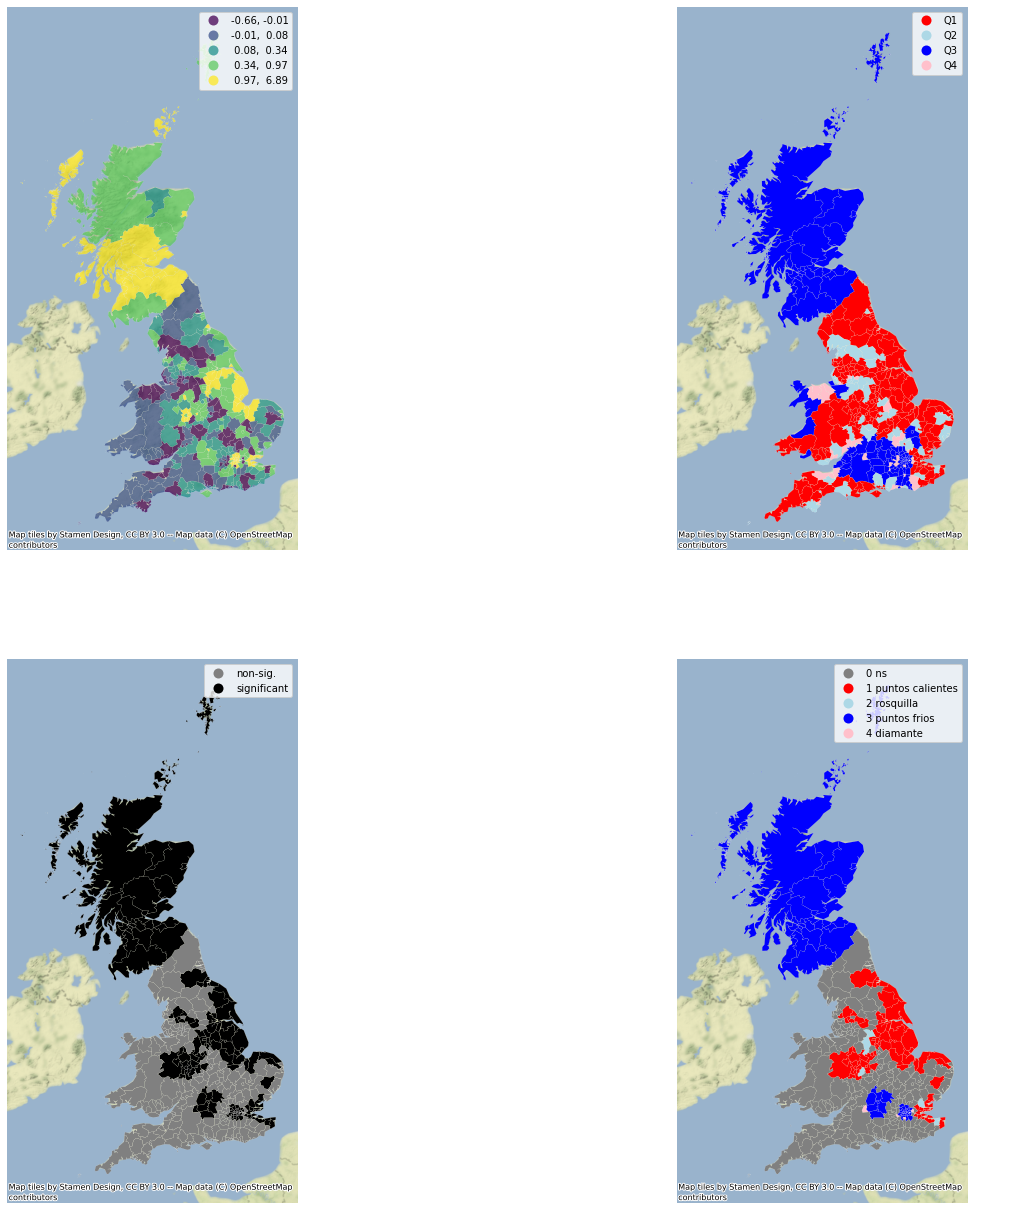

In [19]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(22, 22))
# Make the axes accessible with single indexing
axs = axs.flatten()

                    # Subplot 1 #
ax = axs[0]
db.plot(column='Is', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True, ax=ax)
contextily.add_basemap(ax, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground
                      )
ax.set_aspect('equal')
ax.set_axis_off()

                    # Subplot 2 #
ax = axs[1]
q_labels = ['Q1', 'Q2', 'Q3', 'Q4']
labels = [q_labels[i-1] for i in lisa.q]
hmap = colors.ListedColormap([ 'red', 'lightblue', 'blue', 'pink'])
db.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
contextily.add_basemap(ax, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground
                      )
ax.set_aspect('equal')
ax.set_axis_off()

                    # Subplot 3 #

ax = axs[2]
sig = 1 * (lisa.p_sim < 0.05)
hmap = colors.ListedColormap(['grey','black'])
labels = ['non-sig.', 'significant'] 
labels = [labels[i] for i in sig]
db.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
contextily.add_basemap(ax, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground
                      )
ax.set_aspect('equal')
ax.set_axis_off()
                            
                    # Subplot 4 #
ax = axs[3]
hotspot = 1 * (sig * lisa.q==1)
coldspot = 3 * (sig * lisa.q==3)
doughnut = 2 * (sig * lisa.q==2)
diamond = 4 * (sig * lisa.q==4)
spots = hotspot + coldspot + doughnut + diamond
spot_labels = [ '0 ns', '1 puntos calientes', '2 rosquilla', '3 puntos frios', '4 diamante']
labels = [spot_labels[i] for i in spots]
hmap = colors.ListedColormap([ 'grey', 'red', 'lightblue', 'blue', 'pink'])


db.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
contextily.add_basemap(ax, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground
                      )
ax.set_aspect('equal')
ax.set_axis_off()


# Display the figure
plt.show()

La figura de la esquina superior izquierda reproduce nuestro primer mapa de arriba. Las ubicaciones verde y amarilla tienen los valores más altos para las estadísticas locales, sin embargo, esto no distingue entre una asociación positiva de un bajo apoyo al voto del Brexit y una asociación positiva de un alto apoyo al Brexit.

Para distinguir entre estos dos casos, el mapa de la parte superior derecha muestra la ubicación de la estadística LISA en el cuadrante del diagrama de dispersión de Moran, que se registra en el atributo 'q':

In [28]:
lisa.q[:20]

array([1, 1, 1, 1, 1, 1, 4, 1, 4, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2])

La correspondencia entre los números del qatributo y los cuadrantes reales es la siguiente:

- 1: HH

- 2: LH

- 3: LL

- 4: HL

La comparación de los dos mapas en la fila superior revela que la asociación positiva en el norte se debe al bajo apoyo al voto del Brexit, mientras que la asociación positiva en el sur es del alto apoyo al Brexit. 

En general, podemos obtener recuentos de áreas en cada cuadrante:

In [30]:
counts = [(j,(lisa.q==j).sum()) for j in range(1,5)]
counts

[(1, 183), (2, 50), (3, 113), (4, 34)]

Los valores alto-alto (1) y bajo-bajo (3) son predominantes.

Sin embargo, se debe tener cuidado en la interpretación de estos dos primeros mapas, ya que no se ha considerado la signifcancia estadística subyacente de los valores locales

En cambio, lo que se suele hacer es crear un mapa, un mapa de conglomerados como se le suele llamar, que extrae las observaciones significativas (aquellas que es muy poco probable que provengan de pura casualidad) y las traza con un color específico dependiendo de su categoría del cuadrante.

Todas las piezas necesarias están contenidas dentro del objeto 'lisa' que hemos creado arriba. Pero, para hacer el mapa más sencillo, es conveniente sacarlos e insertarlos en la tabla de datos principal:

In [33]:
sig = 1 * (lisa.p_sim < 0.05)
db['p-sim'] = lisa.p_sim
db['sig'] = sig
db[['sig','p-sim']].head()

,sig,p-sim
lad16cd,,
E06000001,1,0.010
E06000002,1,0.009
E06000003,1,0.016
E06000004,1,0.012
E06000010,1,0.017


In [34]:
db[['sig','p-sim']].tail()

,sig,p-sim
lad16cd,,
W06000018,0,0.475
W06000019,0,0.477
W06000021,0,0.480
W06000022,0,0.355
W06000023,0,0.280


Por lo tanto, los primeros cinco valores son estadísticamente significativos, mientras que las últimas cinco observaciones no lo son.

De manera similar, como ocurre con la I de Moran global, PySAL calcula automáticamente un valor p para cada LISA. Debido a que no todas las observaciones representan una estadísticamente significativa, queremos identificar aquellas con un valor p lo suficientemente pequeño como para descartar la posibilidad de obtener una situación similar por pura casualidad. S

Siguiendo un razonamiento similar al de la I de Moran global, seleccionamos el 5% como el umbral de significación estadística.

A continuación, consideramos el atributo 'q' que significa qué cuadrante es el valor local, pero ahora enmascaramos estos valores usando un indicador de significancia recién creado:

In [36]:
hotspot = 1 * (sig * lisa.q==1)
coldspot = 3 * (sig * lisa.q==3)
doughnut = 2 * (sig * lisa.q==2)
diamond = 4 * (sig * lisa.q==4)
spots = hotspot + coldspot + doughnut + diamond
#spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
spot_labels = [ '0 ns', '1 puntos calientes', '2 rosquillas', '3 puntos frios', '4 diamantes']

También damos etiquetas descriptivas a los cinco casos, donde las ubicaciones con valores p no significativos para las LISA se etiquetan como ns. 

Las formas positivas de autocorrelación espacial local son de dos tipos: agrupamiento significativo de HH, o los llamados **'puntos calientes'**, o agrupamiento significativo de valores LL, o **'puntos fríos'**. 

Las ubicaciones con una autocorrelación local significativa, pero negativa, son **'rosquillas'** donde un valor bajo de apoyo es vecino de ubicaciones con un alto apoyo al Brexit, o **'diamantes'** donde un valor alto está rodeado de valores bajos.

In [39]:
db['labels'] = labels
[(spot_label, (db['labels']==spot_label).sum()) for spot_label in spot_labels]

[('0 ns', 225),
 ('1 puntos calientes', 76),
 ('2 rosquilla', 6),
 ('3 puntos frios', 69),
 ('4 diamante', 4)]